![Image search](https://static.makeuseof.com/wp-content/uploads/2017/08/Google-Images-Search.gif)

# Deep Learning for Unstructured Data: Application to Image Search

#### Aivin V. Solatorio

e-mail: avsolatorio@gmail.com  &emsp; &emsp; &emsp; github: <a href='https://github.com/avsolatorio/'>avsolatorio</a> &emsp; &emsp; &emsp; linkedin: <a href='https://linkedin.com/in/avsolatorio/'>avsolatorio</a>


# Configuration and loading of necessary modules

In [2]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from keras.utils import multi_gpu_model

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.9

set_session(tf.Session(config=config))
print tf.__version__

Using TensorFlow backend.


1.8.0


In [3]:
from PIL import Image
import pandas as pd
import pylab as plt
import numpy as np
import keras
import re

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import ImageDataGenerator

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics.pairwise import cosine_similarity

print keras.__version__

2.1.6


# Load dataset scraped from google images

- The dataset consists of google images of around 50 animals.
- Each animal set contains roughly 500 images.
- Data captured are the image, title, and caption for the image.

![image.png](https://github.com/avsolatorio/image-labeler/blob/master/image-search-sample-image.png?raw=true)

In [4]:
full_data_df = pd.read_hdf('../../data/full_data_common_animals.hdf', 'full_data_df')
full_data_df.head()

,caption,image,image_link,image_type,record_id,title
0,Collage of amphibians,../../data/img_common_animals/amphibians/tOSgy...,https://encrypted-tbn0.gstatic.com/images?q=tb...,png,tOSgylwuq-zi7M:,Amphibian - Wikipedia
1,Amphibians,../../data/img_common_animals/amphibians/BA01z...,https://encrypted-tbn0.gstatic.com/images?q=tb...,jpg,BA01zBROtA6QgM:,Amphibians | San Diego Zoo Animals & Plants
2,,../../data/img_common_animals/amphibians/TKxsc...,https://encrypted-tbn0.gstatic.com/images?q=tb...,jpg,TKxsciksiYOBcM:,amphibians-hero.jpg
3,Snake Head Pops Out of Frog's Maw in Mesmerizi...,../../data/img_common_animals/amphibians/mgGpN...,https://encrypted-tbn0.gstatic.com/images?q=tb...,,mgGpNhsvyK7htM:,Amphibians - 2018 News and Scientific Articles...
4,,../../data/img_common_animals/amphibians/a4k5F...,https://encrypted-tbn0.gstatic.com/images?q=tb...,jpg,a4k5Fu5KAIe9UM:,reticulated glass frog eggs.ngsversion.1465493...


# Text data processing

In [5]:
sample_data = full_data_df[full_data_df.columns.drop(['image_link', 'image_type', 'record_id'])].loc[full_data_df.index]
sample_data = sample_data.drop_duplicates(['image'])

We apply a very simple tokenization procedure: Just use alphanumeric characters in the text data, i.e., captions and titles.

In [6]:
def process_raw_text(x, tokenize=True, filter_symbols=True):
    x = x.lower()
    x = x.replace('.jpg', '')
    x = x.replace('.png', '')
    
    if tokenize:
        x = re.findall("[a-z0-9]+", x)
    else:
        x = re.sub("[^a-z0-9\ ]+", ' ', x)

    return x


sample_data['title_tokens'] = sample_data['title'].map(process_raw_text)
sample_data['caption_tokens'] = sample_data['caption'].map(process_raw_text)

Let's apply Jaccard measure to know if the title is almost the same as the caption. We need to do this to avoid redundancy in the text data.

In [7]:
def jaccard_similarity(row):
    intersection = len(set(row['title_tokens']).intersection(row['caption_tokens']))
    union = len(set(row['title_tokens']).union(row['caption_tokens']))
    
    similarity = 1.0 * intersection / union
    
    return similarity


sample_data['jaccard_sim'] = sample_data.apply(jaccard_similarity, axis=1)

By using the similarity score, we select which text data are used. If the title and the caption are dissimilar based on a threshold, then we use both text (concatenated) as input.

In [8]:
def get_effective_sample_text(row, sim_thresh=0.5):
    token_set = []
    title_tokens = row['title_tokens']
    caption_tokens = row['caption_tokens']
    
    if row['jaccard_sim'] > sim_thresh:
        if len(title_tokens) > len(caption_tokens):
            token_set.extend(title_tokens)
        else:
            token_set.extend(caption_tokens)
    else:
        token_set.extend(title_tokens)
        token_set.extend(caption_tokens)
        
    return token_set


sample_data['tokens'] = sample_data.apply(get_effective_sample_text, axis=1)
sample_data = sample_data.drop(['caption', 'title', 'title_tokens', 'caption_tokens', 'jaccard_sim'], axis=1)

After taking the relevant text data, we retokenize them with a `Tokenizer` utility class from the keras preprocessing module.

Note that the `tokens` data is already a list of words, so we need to join each token together before fitting the tokenizer.

In [9]:
tokenizer = Tokenizer(num_words=10000, filters='', lower=True, split=' ', char_level=False, oov_token=None)
tokenizer.fit_on_texts(sample_data['tokens'].map(lambda x: ' '.join(x)))

We take the histogram of token length for each item in our dataset. With this, we can have an informed choice for our expected sequence length when standardizing the length of the text input.

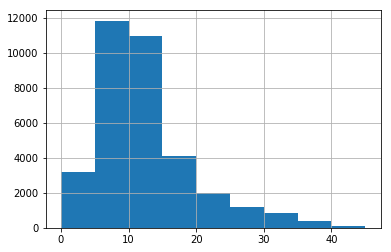

In [10]:
pd.Series([len(i) for i in tokenizer.texts_to_sequences(
    sample_data['tokens'].map(lambda x: ' '.join(x))
)]).hist(bins=range(0, 50, 5))

In [11]:
MAXLEN = 15
EMBEDDING_DIM = 300

In the snippet below, we perform standardization of the text data. The process involves truncation of text sequences longer than our specified `MAXLEN` as well as padding default values to sequences that are shorter than `MAXLEN`. This is required for convenience later in the training procedure.

In [12]:
sample_data['sequence'] = pad_sequences(
    tokenizer.texts_to_sequences(
        sample_data['tokens'].map(lambda x: ' '.join(x))
    ), maxlen=MAXLEN, padding='pre', truncating='post'
).tolist()

sample_data['empty_sequence'] = sample_data.sequence.map(lambda x: sum(x) == 0)
sample_data = sample_data[~sample_data.empty_sequence]
sample_data.shape

(34514, 4)

# How can we use the words in the text as input to our model?

## What are word vectors?


![word vecs](https://adriancolyer.files.wordpress.com/2016/04/word2vec-distributed-representation.png?w=600)

## Special properties of word vectors

![w2v](https://cdn-images-1.medium.com/max/2000/1*sXNXYfAqfLUeiDXPCo130w.png)

## Learning a word vector representation

![wv training](https://www.tensorflow.org/images/softmax-nplm.png)

# Using pretrained word vectors

We can use the word vectors trained with large dataset as prior word vectors for our model. Google (word2vec), Facebook (fasttext), and Stanford (glove) have released some pretrained word vectors to the public domain.

In [13]:
%%time
def get_embedding_index(pre_trained_file, word_index):
    # Expected format is space separated.
    # First item is the word and succedding items are the elements of the vector
    embedding_index = {}
    
    with open(pre_trained_file) as fl:
        for line in fl:
            line = line.strip().split()
            word = line[0]
            vector = line[1:]
            if word in word_index:
                embedding_index[word] = np.array(vector, dtype=np.float32)
                
    return embedding_index


embeddings_index = get_embedding_index(
    pre_trained_file='/mnt/Datastore/WORK/pre-trained-models/glove.840B.300d.txt',
    word_index=tokenizer.word_index
)

CPU times: user 27.3 s, sys: 1.63 s, total: 28.9 s
Wall time: 30 s


Let's build an embedding matrix containing each word vector for our vocabulary. Words not found in the pretrained model are set to random normal vectors. A default vector for padding is set to the zero vector.

In [14]:
%%time
# Keras reserves index 0 for masking
word_index = tokenizer.word_index

print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.random.randn(len(word_index) + 1, EMBEDDING_DIM)
embedding_matrix[0] = np.zeros(EMBEDDING_DIM)

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Found 24418 word vectors.
CPU times: user 413 ms, sys: 21 ms, total: 434 ms
Wall time: 433 ms


# Image data processing

In [15]:
from keras.layers import (
    Input, GRU, Bidirectional, Dense, Conv2D, MaxPooling2D,
    GlobalAveragePooling2D, Flatten, Dropout, LeakyReLU
)
from keras.applications import VGG16

Let's use a pretrained model as well for images to condition our image model. We chose VGG16 model without any special reason (other pretrained models can be used).

In [16]:
image_size = (150, 150, 3)

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=image_size)

In [17]:
# Taken from sklearn and modified to add a `size` attribute
def imread(name, flatten=False, mode=None, size=None):
    """
    Read an image from a file as an array.
    Parameters
    ----------
    name : str or file object
        The file name or file object to be read.
    flatten : bool, optional
        If True, flattens the color layers into a single gray-scale layer.
    mode : str, optional
        Mode to convert image to, e.g. ``'RGB'``.  See the Notes for more
        details.
    Returns
    -------
    imread : ndarray
        The array obtained by reading the image.
    Notes
    -----
    `imread` uses the Python Imaging Library (PIL) to read an image.
    The following notes are from the PIL documentation.
    `mode` can be one of the following strings:
    * 'L' (8-bit pixels, black and white)
    * 'P' (8-bit pixels, mapped to any other mode using a color palette)
    * 'RGB' (3x8-bit pixels, true color)
    * 'RGBA' (4x8-bit pixels, true color with transparency mask)
    * 'CMYK' (4x8-bit pixels, color separation)
    * 'YCbCr' (3x8-bit pixels, color video format)
    * 'I' (32-bit signed integer pixels)
    * 'F' (32-bit floating point pixels)
    PIL also provides limited support for a few special modes, including
    'LA' ('L' with alpha), 'RGBX' (true color with padding) and 'RGBa'
    (true color with premultiplied alpha).
    When translating a color image to black and white (mode 'L', 'I' or
    'F'), the library uses the ITU-R 601-2 luma transform::
        L = R * 299/1000 + G * 587/1000 + B * 114/1000
    When `flatten` is True, the image is converted using mode 'F'.
    When `mode` is not None and `flatten` is True, the image is first
    converted according to `mode`, and the result is then flattened using
    mode 'F'.
    """

    im = Image.open(name)
    
    if size is not None:
        im = im.resize(size)
        
    return fromimage(im, flatten=flatten, mode=mode)


def fromimage(im, flatten=False, mode=None):
    """
    Return a copy of a PIL image as a numpy array.
    Parameters
    ----------
    im : PIL image
        Input image.
    flatten : bool
        If true, convert the output to grey-scale.
    mode : str, optional
        Mode to convert image to, e.g. ``'RGB'``.  See the Notes of the
        `imread` docstring for more details.
    Returns
    -------
    fromimage : ndarray
        The different colour bands/channels are stored in the
        third dimension, such that a grey-image is MxN, an
        RGB-image MxNx3 and an RGBA-image MxNx4.
    """
    if not Image.isImageType(im):
        raise TypeError("Input is not a PIL image.")

    if mode is not None:
        if mode != im.mode:
            im = im.convert(mode)
    elif im.mode == 'P':
        # Mode 'P' means there is an indexed "palette".  If we leave the mode
        # as 'P', then when we do `a = array(im)` below, `a` will be a 2-D
        # containing the indices into the palette, and not a 3-D array
        # containing the RGB or RGBA values.
        if 'transparency' in im.info:
            im = im.convert('RGBA')
        else:
            im = im.convert('RGB')

    if flatten:
        im = im.convert('F')
    elif im.mode == '1':
        # Workaround for crash in PIL. When im is 1-bit, the call array(im)
        # can cause a seg. fault, or generate garbage. See
        # https://github.com/scipy/scipy/issues/2138 and
        # https://github.com/python-pillow/Pillow/issues/350.
        #
        # This converts im from a 1-bit image to an 8-bit image.
        im = im.convert('L')

    a = np.array(im)
    return a


def recast_array_to_image(float_array):
    uint_array = (float_array * 255 / np.max(float_array)).astype('uint8')

    return Image.fromarray(uint_array)


image_cache = {}

def load_image(path, size=image_size[:-1], as_float=True):
    if path not in image_cache:
        
        im = imread(path, size=size)
        
        if as_float:
            im = im.astype(np.float32)
            
        image_cache[path] = im
        
    return image_cache[path]

We perform preprocessing of the images by standardizing their sizes and scaling the values from 0-255 to 0-1.

In [18]:
%%time
image_datagen = ImageDataGenerator(
    rescale=1./255
)

sample_data['image_array'] = conv_base.predict(
    image_datagen.flow(
        np.stack(sample_data['image'].map(load_image)),
        batch_size=sample_data.shape[0], shuffle=False
    ).next()
).tolist()

sample_data.head()

CPU times: user 1min 42s, sys: 27.1 s, total: 2min 9s
Wall time: 2min 10s


## Implementing a data generator for training

In [19]:
def pretrain_model_image_generator(image_data, batch_size):
    image_datagen = ImageDataGenerator(
        rescale=1./255
    )

    # Exploit image_datagen for dynamic perturbation of the data    
    image_data = image_datagen.flow(
        image_data,
        batch_size=len(image_data), shuffle=False
    ).next()
    
    image_data = conv_base.predict(image_data)
    
    for i in range(0, len(image_data) // batch_size):
        yield image_data[i * batch_size: (i + 1) * batch_size]

In [ ]:
def dataset_generator(dataset, batch_size=32, shuffle=True, negative_fold=1):
    index = np.array(dataset.index.values)  # Interestingly, data gets shuffled if we don't use np.array to create a new object!
    full_batch_size = batch_size * (negative_fold + 1)

    batch_index = []
    while True:
        
        if shuffle:
            np.random.shuffle(index)

        for i in index:
            if len(batch_index) < batch_size:
                batch_index.append(i)

            else:
                positive_df = dataset.loc[batch_index]
                
                batch_image_data = np.stack(positive_df['image_array'])
                positive_text_data = np.stack(positive_df['sequence'])
                
                if negative_fold:
                    batch_image_data = np.vstack([batch_image_data] * (negative_fold + 1))

                    negative_index = np.random.choice(index, size=batch_size * negative_fold, replace=True)
                    negative_text_data = np.stack(dataset.loc[negative_index]['sequence'])
                
                    text_data = np.vstack([positive_text_data, negative_text_data])
                else:
                    text_data = positive_text_data
                
                label = np.zeros(full_batch_size)
                label[:batch_size] = 1
                
                ix = np.array(range(full_batch_size))
                if shuffle:
                    ix = np.random.choice(ix, size=full_batch_size, replace=False)
                
                batch_index = []
                yield [text_data[ix], batch_image_data[ix]], label[ix]
#                 yield [text_data[ix], conv_base.predict(batch_image_data[ix])], label[ix]

In [20]:
%%time
data_gen = dataset_generator(sample_data, batch_size=32, shuffle=True, negative_fold=2)
q = data_gen.next()

CPU times: user 23.4 ms, sys: 671 µs, total: 24.1 ms
Wall time: 34.9 ms


# Building the model

The model consists of two parts

Text model

Image model

Our objective is to train these two models jointly such that they will share the same vector space.

## Text model

In [21]:
text_model_input = keras.layers.Input(shape=(MAXLEN,))
text_embedding = keras.layers.Embedding(
    input_dim=len(word_index) + 1, output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    trainable=False,
    mask_zero=True
)(text_model_input)

text_gru = Bidirectional(GRU(64, return_sequences=False))(text_embedding)
text_dense = Dense(300, activation='relu')(text_gru)
text_dense = Dropout(0.3)(text_dense)

text_model_output = Dense(200, activation='tanh')(text_dense)

TextModel = keras.models.Model(inputs=[text_model_input], outputs=[text_model_output])

In [53]:
# SVG(model_to_dot(TextModel).create(prog='dot', format='svg'))

## Image model

# Convolutional Network

![Conv](https://adeshpande3.github.io/assets/Cover.png)

In [23]:
image_model_input = Input(shape=(4, 4, 512))

image_conv = Conv2D(64, 2)(image_model_input)
image_pool = MaxPooling2D(pool_size=(2, 2))(image_conv)

image_flatten = Flatten()(image_pool)

image_input_pool = MaxPooling2D(pool_size=(2, 2))(image_model_input)
image_input_flatten = Flatten()(image_input_pool)

full_image = keras.layers.concatenate([image_input_flatten, image_flatten])
image_model_output = Dense(200, activation='tanh')(full_image)  # full_image_dense)


ImageModel = keras.models.Model(inputs=[image_model_input], outputs=[image_model_output])

In [24]:
# SVG(model_to_dot(ImageModel).create(prog='dot', format='svg'))

## Image Search model

In [25]:
image_search_ouput = keras.layers.merge([text_model_output, image_model_output], mode='cos')
image_search_ouput = keras.layers.Reshape((1,), input_shape=(1, 1))(image_search_ouput)

ImageSearchModel = keras.models.Model(inputs=[text_model_input, image_model_input], outputs=[image_search_ouput])

ImageSearchModel.compile(
    optimizer='adam',
    loss='binary_crossentropy'
)

In [26]:
# SVG(model_to_dot(ImageSearchModel).create(prog='dot', format='svg'))

In [27]:
ImageSearchModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 4, 4, 512)    0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 15, 300)      9454800     input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 3, 3, 64)     131136      input_3[0][0]                    
__________________________________________________________________________________________________
bidirectio

# Training the model

In [28]:
%%time
ImageSearchModel.fit_generator(data_gen, steps_per_epoch=full_data_df.shape[0] // 32, epochs=10)

Epoch 1/10
1090/1090 [==============================] - 31s 28ms/step - loss: 0.5976
Epoch 2/10
1090/1090 [==============================] - 30s 27ms/step - loss: 0.5659
Epoch 3/10
1090/1090 [==============================] - 30s 27ms/step - loss: 0.5461
Epoch 4/10
1090/1090 [==============================] - 30s 27ms/step - loss: 0.5283
Epoch 5/10
1090/1090 [==============================] - 30s 27ms/step - loss: 0.5073
Epoch 6/10
1090/1090 [==============================] - 30s 27ms/step - loss: 0.4893
Epoch 7/10
1090/1090 [==============================] - 30s 27ms/step - loss: 0.4778
Epoch 8/10
1090/1090 [==============================] - 30s 27ms/step - loss: 0.4589
Epoch 9/10
1090/1090 [==============================] - 30s 27ms/step - loss: 0.4508
Epoch 10/10
1090/1090 [==============================] - 30s 27ms/step - loss: 0.4339
CPU times: user 9min 46s, sys: 34.3 s, total: 10min 20s
Wall time: 4min 58s


In [31]:
%%time
ImageSearchModel.fit_generator(data_gen, steps_per_epoch=full_data_df.shape[0] // 32, epochs=100)

In [30]:
%%time
ImageSearchModel.fit_generator(data_gen, steps_per_epoch=full_data_df.shape[0] // 32, epochs=10)

Epoch 1/10
1090/1090 [==============================] - 30s 27ms/step - loss: 0.2102
Epoch 2/10
1090/1090 [==============================] - 29s 27ms/step - loss: 0.2114
Epoch 3/10
1090/1090 [==============================] - 29s 27ms/step - loss: 0.2103
Epoch 4/10
1090/1090 [==============================] - 30s 27ms/step - loss: 0.2105
Epoch 5/10
1090/1090 [==============================] - 30s 27ms/step - loss: 0.2109
Epoch 6/10
1090/1090 [==============================] - 30s 27ms/step - loss: 0.2102
Epoch 7/10
1090/1090 [==============================] - 30s 27ms/step - loss: 0.2089
Epoch 8/10
1090/1090 [==============================] - 30s 27ms/step - loss: 0.2078
Epoch 9/10
1090/1090 [==============================] - 29s 27ms/step - loss: 0.2062
Epoch 10/10
1090/1090 [==============================] - 30s 27ms/step - loss: 0.2066
CPU times: user 9min 43s, sys: 32.4 s, total: 10min 15s
Wall time: 4min 55s


# Transforming images to embedding vectors

In [32]:
%%time
image_embeddings = ImageModel.predict(np.stack(sample_data['image_array'].values))
image_embeddings.shape

CPU times: user 6.72 s, sys: 1.12 s, total: 7.84 s
Wall time: 7.35 s


# Making a text query

We process the query using the pipeline used in transforming our training data.

In [42]:
text_query = "the pool with dogs and cats"

seq = pad_sequences(
    tokenizer.texts_to_sequences(
        [' '.join(process_raw_text(text_query))]
    ), maxlen=MAXLEN, padding='pre', truncating='post'
)
query_vector = TextModel.predict(seq)
seq

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    1, 2471,
          15,  196,    4,  152]], dtype=int32)

We then compute the `cosine similarity` of the query vector against the image embedding vectors.

In [43]:
%%time
res = cosine_similarity(image_embeddings, query_vector)

top_ix = res[:, 0].argsort()[::-1][:10]

print(res[:, 0][top_ix])
print(top_ix)

sample_data.iloc[top_ix].head()

[0.86090755 0.8450707  0.83659077 0.83162266 0.83036536 0.83012605
 0.81975794 0.813124   0.8059485  0.8049206 ]
[ 1811 11496 20198   763  1573  1537 25993  1684  1130  1176]
CPU times: user 46.3 ms, sys: 74.6 ms, total: 121 ms
Wall time: 29.1 ms


Retrieved images

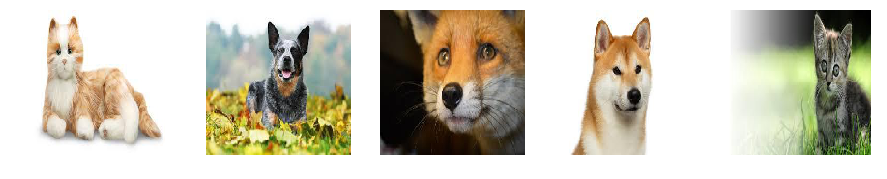

In [44]:
plt.figure(figsize=(15, 5))

for ix, iloc in enumerate(top_ix[:5]):
    im = Image.fromarray(
        load_image(
            sample_data.iloc[iloc]['image'],
            size=None,
        ).astype(np.uint8)
    )
    plt.subplot(int('15{}'.format(ix + 1)))
    plt.imshow(np.asarray(im))
    plt.axis('off')

# Query by image

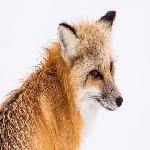

In [54]:
iloc = 30194
# iloc = 20194

im = Image.fromarray(
    load_image(
        sample_data.iloc[iloc]['image'],
        size=None, 
    ).astype(np.uint8)
)
im

In [55]:
image_query = ImageModel.predict(np.stack(sample_data.iloc[[iloc]].image_array.values))
res_im = cosine_similarity(image_embeddings, image_query)

top_im_ix = res_im[:, 0].argsort()[::-1][:10]

print(res_im[:, 0][top_im_ix])
print(top_im_ix)

sample_data.iloc[top_im_ix].head()

[0.99999964 0.98442847 0.98420405 0.97683805 0.9685759  0.96544635
 0.96136504 0.95940375 0.9588451  0.95852727]
[20194 20335 18018  6810 20234 20266 20187 20211 18570 20505]


,image,tokens,sequence,empty_sequence,image_array
20463,../../data/img_common_animals/red-fox/l4D7Bylp...,"[red, fox, wildlife, snow, free, photo, on, pi...","[20, 32, 27, 133, 35, 21, 9, 256, 20, 32, 27, ...",False,"[[[0.122547864914, 0.0, 0.0, 0.0, 0.0539604946..."
20604,../../data/img_common_animals/red-fox/zuEcpM5B...,"[red, fox, elmwood, park, zoo, elmwood, park, ...","[0, 0, 0, 20, 32, 8676, 98, 34, 8676, 98, 34, ...",False,"[[[0.130790114403, 0.0, 0.0, 0.0, 0.1832721084..."
18279,../../data/img_common_animals/coyote/Xh_8alpCI...,"[coyote, spirit, animal, totem, meaning]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 62, 481, 24, 10...",False,"[[[0.228968769312, 0.0, 0.0, 0.0, 0.0927995666..."
6905,../../data/img_common_animals/gray-wolf/excS24...,"[great, lakes, gray, wolf]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 135, 2989, 7...",False,"[[[0.0, 0.0, 0.312162518501, 0.019131347537, 0..."
20503,../../data/img_common_animals/red-fox/ValbH3lt...,"[red, fox, adoption, kit, canadian, wildlife, ...","[0, 20, 32, 671, 893, 308, 27, 2134, 1470, 543...",False,"[[[0.106955885887, 0.0, 0.0, 0.0, 0.2613540887..."


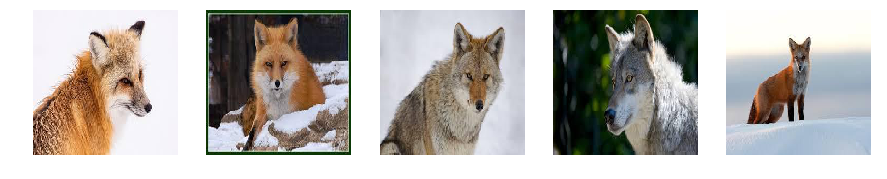

In [56]:
plt.figure(figsize=(15, 5))

for ix, iloc in enumerate(top_im_ix[:5]):
    im = Image.fromarray(
        load_image(
            sample_data.iloc[iloc]['image'],
            size=None, 
        ).astype(np.uint8)
    )
    plt.subplot(int('15{}'.format(ix + 1)))
    plt.imshow(np.asarray(im))
    plt.axis('off')

In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
#         'width': 1024,
#         'height': 768,
        'scroll': True,
})

{'scroll': True}